In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from math import log, sqrt

import sys
sys.path.append('../utils')
from round_result import *
from gradient_descent import *
from pretty_print import *

In [2]:
# wczytanie i parsowanie danych
wine = pd.read_csv('../datasets/winequality-white.csv', sep=';')

wine_f = wine.drop('quality', axis=1)
wine_q = wine['quality']

F_train, F_test, Q_train, Q_test = train_test_split(wine_f, wine_q, test_size=0.2, random_state=76)
# dobre random states = [1, 6]

In [3]:
# standaryzacja - odchylenie standardowe
F_train1 = (F_train - F_train.mean()) / F_train.std()
F_test1 = (F_test - F_train.mean()) / F_train.std()

# standaryzacja - boxcox power transform
F_train2 = pd.DataFrame()
F_test2 = pd.DataFrame()
for c in F_train.columns:

	if c == 'citric acid': # jedyny zawiera cechy niedodatnie
		tmp_train = F_train[c].apply(lambda x: 0.0001 if x == 0 else x)
		tmp_test = F_test[c].apply(lambda x: 0.0001 if x == 0 else x)
		
		F_train2[c], lmbda = stats.boxcox(tmp_train)
		F_test2[c] = stats.boxcox(tmp_test, lmbda=lmbda)
		continue

	F_train2[c], lmbda = stats.boxcox(F_train[c])
	F_test2[c] = stats.boxcox(F_test[c], lmbda=lmbda)

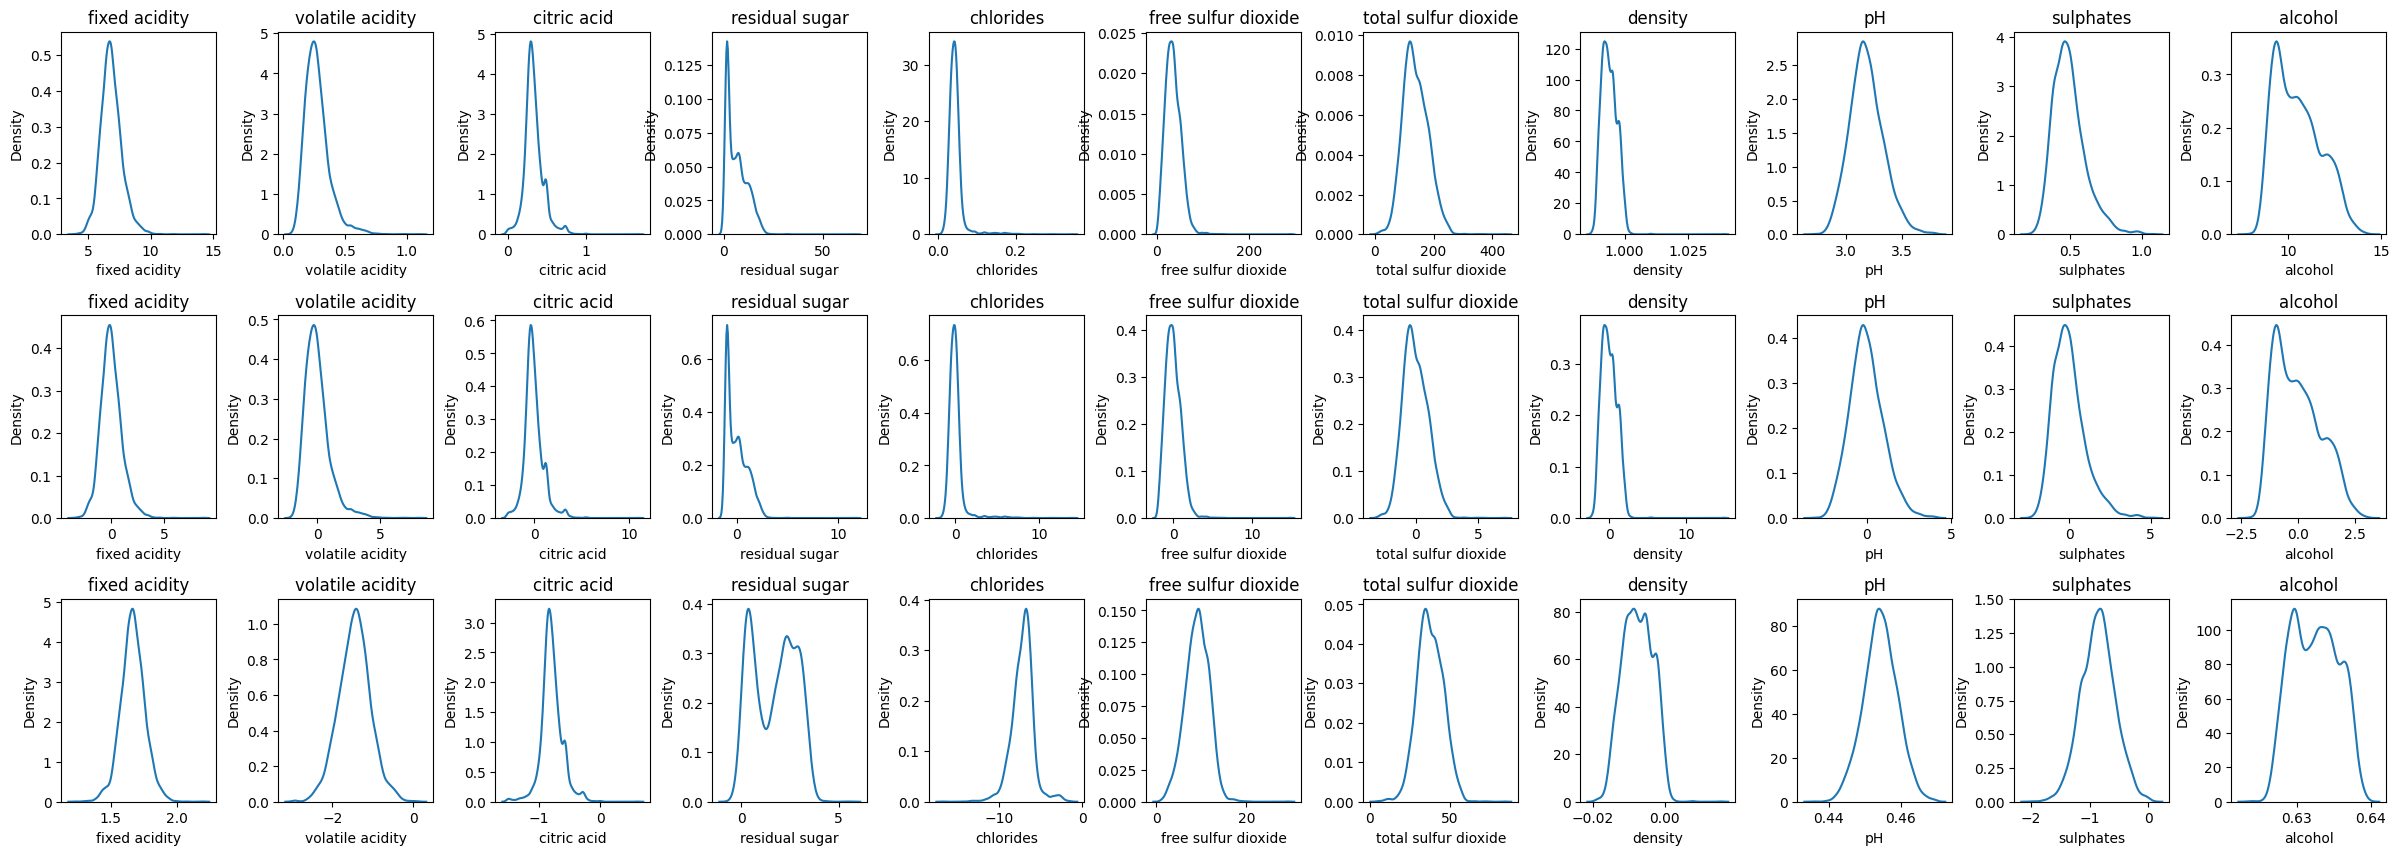

In [4]:
fig, axes = plt.subplots(3, len(F_train.columns))
fig.set_size_inches(30, 10)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# wizualizacja - dane niestandaryzowane
for ax, attr in zip(axes.flatten()[:11], F_train.columns):
	sns.kdeplot(data=F_train, x=attr, ax=ax)
	ax.set_title(attr)

# wizualizacja - std
for ax, attr in zip(axes.flatten()[11:22], F_train.columns):
	sns.kdeplot(data=F_train1, x=attr, ax=ax)
	ax.set_title(attr)

# wizualizacja - boxcox
for ax, attr in zip(axes.flatten()[22:], F_train.columns):
	sns.kdeplot(data=F_train2, x=attr, ax=ax)
	ax.set_title(attr)

In [5]:
# wybor standaryzacji do dalszej analizy 
# 1 -> std, 2 -> boxcox, nic -> żadna (niezalecane)
F_train = F_train2
F_test = F_test2

In [6]:
# walidacja krzyzowa celem wybrania najlepszego alpha dla Lasso
param_grid = { 'alpha': [0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1] }
grid_lasso = GridSearchCV(Lasso(fit_intercept=False, max_iter=10000), param_grid=param_grid, cv=5)
grid_lasso.fit(F_train, Q_train)
print(f'GridCV: Najlepszy param: {grid_lasso.best_params_} z wynikiem: {grid_lasso.best_score_:.5f}\n')

# to samo tylko z natywna metoda, nic nie zmienia tez jest tendencja ze im mniejsze alpha tym lepiej
cv_lasso = LassoCV(fit_intercept=False, max_iter=10000, cv=5) # , alphas=param_grid['alpha'])
cv_lasso.fit(F_train, Q_train)

print(f'LassoCV: Najlepszy alpha: {cv_lasso.alpha_} spośród {cv_lasso.n_alphas} wartości\n')

# model lasso z wykorzystaniem najlepszego wsp regularyzacji
model_lasso = Lasso(alpha=grid_lasso.best_params_['alpha'], fit_intercept=False)
model_lasso.fit(F_train, Q_train)

# CECHY DO UZYCIA W SZKOLENIU MODELU REGRESJI GRZBIETOWEJ
lasso_f = []
for c, v in zip(wine_f.columns, model_lasso.coef_):
	if v > 0:
		lasso_f.append(c)
		print(f'{c:20}: {v}')

# model dla samego L1
Q_res_train = model_lasso.predict(F_train)
pretty_print(round_result(Q_train, Q_res_train)[1])

GridCV: Najlepszy param: {'alpha': 0.005} z wynikiem: 0.14224

LassoCV: Najlepszy alpha: 0.22065760891167102 spośród 100 wartości

fixed acidity       : 0.39752989797305033
residual sugar      : 0.01196340428190966
free sulfur dioxide : 0.062069089984465885
pH                  : 0.4002926066617974
sulphates           : 0.030858274117296965
alcohol             : 4.561448209295427
rounding_num       : 2192
rounding_sum       : 876.8046116554638
rounding_mean_abs  : 0.2237888238018029
rounding_mean_sqrt : 0.07094718397830165
actual_num         : 2104
actual_sum         : 2534.720611348144
actual_mean_abs    : 0.6469424735447024
actual_mean_sqrt   : 0.6994992963710054




C:\Users\mihawb\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.218e+03, tolerance: 1.386e+01
  model = cd_fast.enet_coordinate_descent(


In [7]:
# ograniczenie macierzy cech do zbioru wybranego przez model L1
F_train_lim = F_train[lasso_f]
F_test_lim = F_test[lasso_f]

# walidacja krzyzowa K-Fold
grid = GridSearchCV(Ridge(fit_intercept=False), param_grid=param_grid, cv=5)
grid.fit(F_train_lim, Q_train)
print(f'GridCV: Najlepszy param: {grid.best_params_} z wynikiem: {grid.best_score_:.5f}\n')

# walidacja Leave-One-Out dla regresji grzbietowej
cv_ridge = RidgeCV(fit_intercept=False, cv=5, alphas=param_grid['alpha'])
cv_ridge.fit(F_train_lim, Q_train)

print(f'RidgeCV: Najlepszy alpha: {cv_ridge.alpha_}\n')

# model regresji grzbietowej ze wszystkimi trickami
model_ridge = Ridge(alpha=grid.best_params_['alpha'], fit_intercept=False)
model_ridge.fit(F_train_lim, Q_train)

# dla zbioru uczącego
Q_res_train = model_ridge.predict(F_train_lim)
pretty_print(round_result(Q_train, Q_res_train)[1])

# dla zbioru testowego
Q_res_test = model_ridge.predict(F_test_lim)
Q_res_test_round, errors = round_result(Q_test, Q_res_test)
pretty_print(errors)

GridCV: Najlepszy param: {'alpha': 0.005} z wynikiem: 0.06881

RidgeCV: Najlepszy alpha: 0.005

rounding_num       : 2765
rounding_sum       : 711.9688773183432
rounding_mean_abs  : 0.18171742657436019
rounding_mean_sqrt : 0.049126723672939396
actual_num         : 2218
actual_sum         : 2631.2907945281318
actual_mean_abs    : 0.6715902997774711
actual_mean_sqrt   : 0.7544831926904926


rounding_num       : 696
rounding_sum       : 178.28498936486162
rounding_mean_abs  : 0.18192345853557307
rounding_mean_sqrt : 0.04935884216990103
actual_num         : 485
actual_sum         : 573.9332351652579
actual_mean_abs    : 0.5856461583318958
actual_mean_sqrt   : 0.603425933067353




In [8]:
do_data_viewera = pd.DataFrame()
do_data_viewera['test actual Q'] = Q_test
do_data_viewera['pred. round Q'] = Q_res_test_round
do_data_viewera['predicted Q'] = Q_res_test
do_data_viewera['same'] = Q_test == Q_res_test_round

model_ridge.coef_

array([-1.57906587e+00, -4.78745615e-02,  2.69358778e-02, -2.80357324e+01,
        1.75791251e-01,  3.35828560e+01])